# A/B-тестирование в рамках работы с отделом маркетинга интернет-магазина.

# Описание проекта

В рамках совместной работы с отделом маркетинга интернет-магазина был подготовлен список гипотез для увеличения выручки.

<b> Цель исследования: </b> <br> необходимо приотизировать гипотезы, провести A/B-тестирование и проанализировать результаты с т.зр. влияния метрик на изменение выручки.

<b> В ходе исследования </b> применены методы `ICE` и `RICE` для приоритезации гипотез, изучены следующие метрики: кумулятивная выручка, размер среднего чека, среднее количество заказов на посетителя.

На основании указанных метрик, а также определения границ аномальных значений и определения статистической значимости различий между группами, сформировано итоговое решение о результатах А/В тестирования.

# План работы:

1. Загрузка данных
2. Предобработка данных 
3. Приоритезация гипотез
4. Анализ A/B-теста.<br>
5. Общие выводы<br>

# Описание данных

Для проведения анализа нам предоставлены три csv-файла с информацией о гипотезах, заказах и посетителях интернет-магазина.

Информация о гипотезах хранится в файле `hypothesis.csv`

- `Hypothesis` - краткое описание гипотезы
- `Reach` - охват пользователей по 10-балльной шкале
- `Impact` - влияние на пользователей по 10-балльной шкале
- `Confidence` - уверенность в гипотезе по 10-балльной шкале
- `Efforts` - затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Информация о заказах хранится в файле `orders.csv`

- `transactionId` - идентификатор заказа
- `visitorId` - идентификатор пользователя, совершившего заказ
- `date` - дата, когда был совершён заказ
- `revenue` - выручка заказа
- `group` -  группа A/B-теста, в которую попал заказ.


Информация о посетителях интернет-магазина хранится в файле `visitors.csv`

- `date` - дата
- `group` - группа A/B-теста
- `visitors` - количество пользователей в указанную дату в указанной группе A/B-теста.

<a id="load_data"></a>
# Загрузка данных

Импортируем библиотеки и установим цветовую палитру по умолчанию, параллельно сняв ограничение на число отображаемых символов в записи.

In [2]:
from math import factorial
from math import sqrt
from scipy import stats as st

import pandas as pd
import numpy as np
import datetime as dt

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from decimal import Decimal

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
sns.set_theme(style="whitegrid", palette="pastel")

Загрузим данные из файлов и проанализируем общую информацию о них.

In [5]:
try:
    hypothesis, orders, visitors = (pd.read_csv('/datasets/hypothesis.csv'),
                                   pd.read_csv('/datasets/orders.csv'),
                                   pd.read_csv('/datasets/visitors.csv'))
except:
    hypothesis, orders, visitors = (pd.read_csv('D:/Работа, курсы, обучение+книги/Курсы, самообучение/!DA Plus Yandex/10th sprint/Project/hypothesis.csv'),
                                   pd.read_csv('D:/Работа, курсы, обучение+книги/Курсы, самообучение/!DA Plus Yandex/10th sprint/Project/orders.csv'),
                                   pd.read_csv('D:/Работа, курсы, обучение+книги/Курсы, самообучение/!DA Plus Yandex/10th sprint/Project/visitors.csv'))

In [6]:
# функция для вывода необходимых характеристик датафрейма

def data_info(data):
    print('\033[1;30m информация о датафрейме: \033[0m\n')
    data.info()
    print('\n\033[1;30m выборочные пять строк датафрейма: \033[0m')
    display(data.sample(5))
    print('\n\033[1;30m количество пропусков в столбцах: \033[0m')
    display(data.isna().sum().sort_values())
    print('\n\033[1;30m количество явных дубликатов: \033[0m', data.duplicated().sum())
    print('\n\033[1;30m описание числовых столбцов: \033[0m')
    display(data.describe())

In [7]:
tables = [hypothesis, orders, visitors]
names = ['hypothesis','orders', 'visitors']

for name, table in zip(names, tables):
    print(f'\n\033[7;30m таблица:  {name}\033[0m\n')
    data_info(table)


 таблица:  hypothesis

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

 выборочные пять строк датафрейма: 


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3



 количество пропусков в столбцах: 


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000



 таблица:  orders

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

 выборочные пять строк датафрейма: 


,transactionId,visitorId,date,revenue,group
850,3834417582,4205543768,2019-08-05,2674,B
158,1102655019,1826088570,2019-08-22,11990,B
1135,453686528,2134820861,2019-08-13,18893,A
695,2235924775,473299164,2019-08-09,5776,B
670,1096121493,1722729964,2019-08-29,620,B



 количество пропусков в столбцах: 


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06



 таблица:  visitors

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

 выборочные пять строк датафрейма: 


,date,group,visitors
20,2019-08-21,A,646
42,2019-08-12,B,543
35,2019-08-05,B,707
25,2019-08-26,A,722
51,2019-08-21,B,656



 количество пропусков в столбцах: 


date        0
group       0
visitors    0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


Посмотрим на ключевые значения данных в столбце revenue датафрейма orders в более удобном для заказчика виде:

In [8]:
display(f'Минимальная выручка от заказа составляет {orders["revenue"].min()} ден. ед.')
display(f'Максимальная выручка от заказа составляет {orders["revenue"].max()} ден. ед.')
display(f'Средняя выручка от заказа составляет {round(orders["revenue"].mean(),2)} ден. ед.')
display(f'Медианная выручка от заказа составляет {orders["revenue"].median()} ден. ед.')

'Минимальная выручка от заказа составляет 50 ден. ед.'

'Максимальная выручка от заказа составляет 1294500 ден. ед.'

'Средняя выручка от заказа составляет 8348.01 ден. ед.'

'Медианная выручка от заказа составляет 2978.0 ден. ед.'

<a id="preprocessing"></a>
# Предобработка данных

Внесем заявленные ранее корректировки в стилистику наименований столбцов и типы данных в столбцах с датой.

In [9]:
# Названия столбцов таблицы hypothesis приведем к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

# таблицы orders - в соответствии с правилами хорошего стиля (змеиного регистра), где необходимо. 
orders.columns = [x.replace('Id', '_id') for x in orders.columns]
#orders.columns = [name.replace('Id', '_id') for name in orders.columns]

# заменим тип данных столбцов с датой на datetime
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [10]:
display(orders.sample())
display(hypothesis.sample())
display(visitors.sample())

,transaction_id,visitor_id,date,revenue,group
1172,3898641900,3803269165,2019-08-14,790,B


,hypothesis,reach,impact,confidence,efforts
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,date,group,visitors
28,2019-08-29,A,577


Посмотрим на сроки проведения теста для группы А и В в рамках предоставленных нам таблиц с заказами и посетителями

In [11]:
print(f'\nПромежуток дат, в который осуществлялись заказы группой А: c \033[1;30m{orders[orders["group"]=="A"]["date"].dt.date.min()}\033[0m по \033[1;30m{orders[orders["group"]=="A"]["date"].dt.date.max()}\033[0m\
        \nПромежуток дат, в который осуществлялись заказы группой В: c \033[1;30m{orders[orders["group"]=="B"]["date"].dt.date.min()}\033[0m по \033[1;30m{orders[orders["group"]=="B"]["date"].dt.date.max()}\033[0m')


Промежуток дат, в который осуществлялись заказы группой А: c 2019-08-01 по 2019-08-31        
Промежуток дат, в который осуществлялись заказы группой В: c 2019-08-01 по 2019-08-31


In [12]:
print(f'\nТест для группы А проходил c \033[1;30m{visitors[visitors["group"]=="A"]["date"].dt.date.min()}\033[0m по \033[1;30m{visitors[visitors["group"]=="A"]["date"].dt.date.max()}\033[0m\
        \nТест для группы B проходил c \033[1;30m{visitors[visitors["group"]=="B"]["date"].dt.date.min()}\033[0m по \033[1;30m{visitors[visitors["group"]=="B"]["date"].dt.date.max()}\033[0m')


Тест для группы А проходил c 2019-08-01 по 2019-08-31        
Тест для группы B проходил c 2019-08-01 по 2019-08-31


В обеих таблицах сроки проведения теста для двух групп совпадают. Тест длился один месяц.
Посмотрим как распределялись пользователи по группам

Изучим распределение пользователей по группам. Начнем с таблицы visitors.

In [13]:
visitors.groupby('group')['date'].count()

group
A    31
B    31
Name: date, dtype: int64

In [14]:
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

In [15]:
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

Доли пользователей в таблице visitors равны: пользователи из группы А и В принимали участие в идентичном числе исследований.

In [16]:
print(f'Относительное различие количества пользователей в группе А и В незначительно и составляет порядка {1 - visitors.groupby("group").visitors.sum().values[0]/visitors.groupby("group").visitors.sum().values[1]:.2%} ')

Относительное различие количества пользователей в группе А и В незначительно и составляет порядка 0.95% 


Посмотрим на распределение пользователей в таблице orders.

In [17]:
dist_gr_orders = orders.groupby('group')['visitor_id'].nunique().reset_index()
dist_gr_orders

,group,visitor_id
0,A,503
1,B,586


In [18]:
print(f'Относительное различие количества пользователей\
в таблице orders - {round((1-dist_gr_orders["visitor_id"][0]/dist_gr_orders["visitor_id"][1])*100)} %')

Относительное различие количества пользователейв таблице orders - 14 %


В данном случае присутствует дисбаланс между участниками.
На практике данной ситуации возникать не должно, на этапе подготовки следует использовать специальные калькуляторы, а также провести АА-тестирование, чтобы проверить корректность деления трафика, подтвердить, что на результаты не влияют аномалии и выбросы в генеральной совокупности, а также, что 
данные отправляются в системы аналитики корректно.

Проверим, не попали ли случайно пользователи и в группу А и в группу В.

In [19]:
douplicated_visitors = orders.groupby('visitor_id')['group'].nunique().reset_index()
douplicated_visitors

,visitor_id,group
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


In [20]:
douplicated_visitors[douplicated_visitors['group']>1]['visitor_id'].count()

58

Фактически у нас имеется 58 уникальных покупателей, которые случайно оказались и в группе А и в группе В. Посмотрим на этих пользователей и на количество покупок, которое они совершили.

In [21]:
douplicated_visitors[douplicated_visitors['group']>1]['visitor_id'].sample(5)

236     963407295
960    3972127743
119     471551937
192     818047933
122     477780734
Name: visitor_id, dtype: int64

In [22]:
# возьмем двух покупателей и посмотрим на ситуацию поподробнее

orders.query('visitor_id == 2038680547 or visitor_id == 1648269707')

,transaction_id,visitor_id,date,revenue,group
32,3666913472,2038680547,2019-08-15,1680,B
117,722060263,2038680547,2019-08-22,760,A
189,4189935502,1648269707,2019-08-17,290,B
227,4267573899,2038680547,2019-08-17,3470,A
279,1101659272,1648269707,2019-08-18,860,A
390,2415738512,2038680547,2019-08-25,270,A
577,3932236947,2038680547,2019-08-04,2800,B
578,1570911533,2038680547,2019-08-04,1530,A
605,1215730747,2038680547,2019-08-04,2540,A
624,1666104258,2038680547,2019-08-29,2420,B


Т.об., мы получили подтверждение, что пользователи действительно попали в обе группы, чего при проведении А/В теста быть не должно.

In [23]:
# сохраним id покупателей, оказавшихся в двух группах

list_dupl_visitor = douplicated_visitors[douplicated_visitors['group']>1]['visitor_id']

In [24]:
orders.query('visitor_id in @list_dupl_visitor')['transaction_id'].count()

181

58 пользователей, попавших в обе группы тестирования совершили 181 покупку. Удалим данных пользователей, т.к. в последующем мы не можем с уверенностью оценить, что изменение произошло именно из-за новой идеи, а не потому что это типичное поведение пользователя.

In [25]:
orders = orders.query('visitor_id not in  @list_dupl_visitor').reset_index(drop=True)

<b> Вывод по предобработке данных: </b>

- в рамках предобработки данных мы исправили тип данных в столбцах с датой с object на datetime, внесли корректировки в стилистику написания наименований столбцов;
- длительность проведения А/В-теста составила 1 месяц (август 2019);
- в таблице `orders` нами был выявлен дисбаланс в количестве пользователей между группами, кроме того 58 уникальных покупателей при проведении A/B-теста попали в обе группы тестирования, что может исказить результаты тестирования, в связи с этим мы исключили данных пользователей из анализа. Указанные недочеты с нашей точки зрения следует донести до лиц, ответственных за подготовку к А/В-тестированию, чтобы учесть это при будущих тестах;
- для стоимости заказа (выручки от 1 заказа для интернет-магазина) характерен существенный разброс значений: минимальная стоимость заказа составила 50 ден. ед., максимальная же ~ 1.3 млн ден. ед., средняя стоимость заказа составила около 8348 ден. ед, медианная же стоимость заказа составила 2978 ден. ед., а чек 75% заказов не превышает 8290 ден. ед.д.'

<a id="hypotheses"></a>
# Приоритезация гипотез

В рамках исследования у нас имеется 9 гипотез. <br/> 
Одной из задач нашего исследования является их приоритезация с использованием наиболее популярных методов ICE и RICE.<br/>
Для начала выведем все гипотезы и посмотрим как распределились оценки.

In [26]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<b> Используем метод ICE для приоритезации гипотез.

`ICE SCORE = (Impact * Confidence) / Efforts`  

In [27]:
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']), 2)
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


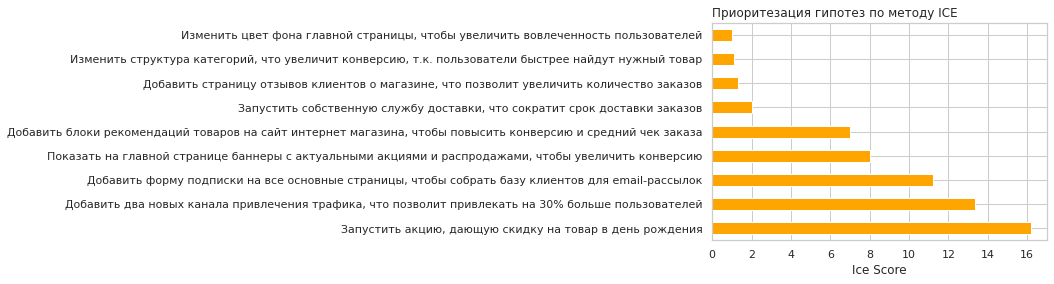

In [28]:
ax = (hypothesis[['hypothesis', 'ice']]
      .set_index('hypothesis')
      .sort_values('ice', ascending=False)
      .plot(kind='barh', color='orange', legend = False)
     )
ax.grid(True)
ax.set_xlabel('Ice Score')
ax.set_ylabel('')
ax.set_title('Приоритезация гипотез по методу ICE', loc='left')
plt.show()

Гипотеза #8 "Запуск акции, дающей скидку на товар в день рождения" - имеет наивысший бал: высокая оценка влияния на пользователей (9) усиливается высокой уверенностью в оценке всех параметров (9), что при относительно небольших усилиях (5) выводит данную гипотезу в лидеры. <br>
<b> Добавим к расчету параметр Reach (Охват) и приоритезируем гипотезы по методу RICE.

`RICE SCORE = (Reach * Impact * Confidence) / Efforts` 

In [29]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


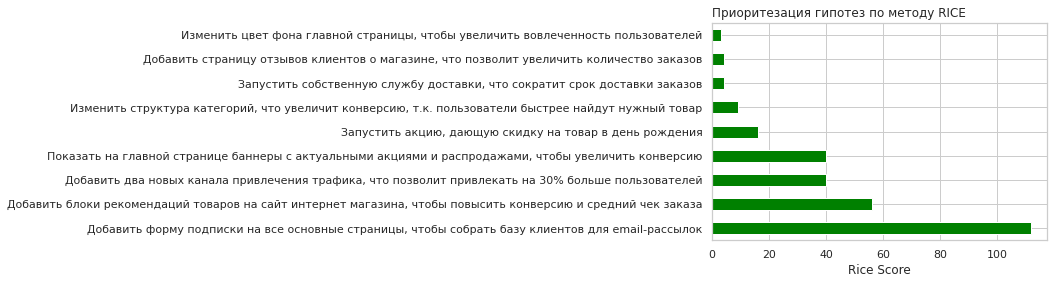

In [30]:
ax = (hypothesis[['hypothesis', 'rice']]
      .set_index('hypothesis')
      .sort_values('rice', ascending=False)
      .plot(kind='barh', color='green', legend = False)
     )
ax.grid(True)
ax.set_xlabel('Rice Score')
ax.set_ylabel('')
ax.set_title('Приоритезация гипотез по методу RICE', loc='left')
plt.show()

Гипотезы с #7 и #0 остались в топ-3, при этом гипотеза о "добавлении формы подписки на все основные страницы" (#7) поднялась на первое место за счет наибольшей оценки по параметру reach (охват). Гипотеза о привлечении двух новых каналов трафика (#0), наоборот, опустилась со второго на третье место, здесь также роль сыграла оценка количества охваченных пользователей в 3 балла. На второе место вышла гипотеза #2 (добавление блоков рекомендаций товаров на сайт интернет-магазина): высокая оценка reach (8 баллов) и низкая оценка сложности реализации данной гипотезы (3 балла). А вот гипотеза, которая была наиболее приоритетной с точки зрения ICE-фреймворка #8 "Запуск акции, дающей скидку на товар в день рождения" опустилась на 5-ую позицию с т.зр. приоритета в связи с низким значением показателя охвата (1 балл).

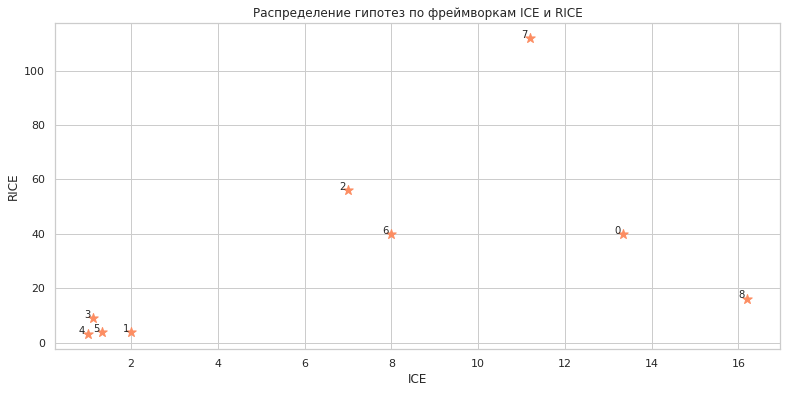

In [31]:
plt.figure(figsize=(13,6))
x = hypothesis['ice'] 
y = hypothesis['rice'] 
tips = hypothesis.index 

plt.scatter(x, y, color='#fc8d62', marker = "*", s=100)

for i, txt in enumerate(tips):
    plt.annotate(txt, (x[i]-.2, y[i]+.1), size = 10)
    
plt.title('Распределение гипотез по фреймворкам ICE и RICE', fontsize=12)
plt.ylabel('RICE')
plt.xlabel('ICE')
plt.show()

# Вывод по приоритезации гипотез:
- приоритет гипотез различается по фреймворкам;
- гипотезы #7 и #0 находятся в топ-3 гипотезах по приоритетности в рамках обоих фреймворков;
- гипотеза #8, лидирующая во фреймворке ICE опустилась с первого места на пятое, в то время как гипотеза #2, наоборот, во фреймфорке RICE поднялась с пятого на второе место. Причиной данного факта является то, что важным моментом в приоритезации гипотезы (в рамках фреймворка RICE) является оценка того, как много пользователей она охватывает: в нашем случае гипотеза #8 имеет параметр reach = 1 (по 10-бальной шкале), в то время как гипотеза #2 = 8, а гипотеза #7 = 10 (максимальный балл).

<a id="analysis"></a>
# Анализ A/B-теста

<a id="cum_rev"></a>
# График кумулятивной выручки по группам.

Прежде чем построить графики по кумулятивным данным соберем соответствующий агрегированный датафрейм, который будет содержать информацию о дате, группе (А или В), кумулятивных количестве заказов и пользователей их оформивших, среднем чеке и о кумулятивном количестве посетителей магазина.

In [32]:
# соз массив уникальных пар значений дат и групп теста
dates_grouped = orders[['date', 'group']].drop_duplicates()
dates_grouped.head()

,date,group
0,2019-08-15,B
6,2019-08-15,A
35,2019-08-16,A
37,2019-08-16,B
45,2019-08-01,A


In [33]:
# получим агрегированные кумулятивные по дням данные о заказах 
orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_grouped.head()

,date,group,transaction_id,visitor_id,revenue
45,2019-08-01,A,23,19,142779
54,2019-08-01,B,17,17,59758
149,2019-08-02,A,42,36,234381
147,2019-08-02,B,40,39,221801
245,2019-08-03,A,66,60,346854


In [34]:
# получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head()

,date,group,visitors
45,2019-08-01,A,719
54,2019-08-01,B,713
149,2019-08-02,A,1338
147,2019-08-02,B,1294
245,2019-08-03,A,1845


In [35]:
# объединяем кумулятивные данные в одной таблице и присвоим ее столбцам соответствующие названия

cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [36]:
# добавим столбец со средним чеком заказа
cumulative_data['avg_check'] = cumulative_data['revenue'] / cumulative_data['orders']

# добавим столбец с отношением заказов к количеству посетителей
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# выведем на экран информацию по первым 6 строкам (число строк увеличим до 6, чтобы видеть полностью 3 даты)
cumulative_data.head(6)

,date,group,orders,buyers,revenue,visitors,avg_check,conversion
0,2019-08-01,A,23,19,142779,719,6207.782609,0.031989
1,2019-08-01,B,17,17,59758,713,3515.176471,0.023843
2,2019-08-02,A,42,36,234381,1338,5580.500000,0.031390
3,2019-08-02,B,40,39,221801,1294,5545.025000,0.030912
4,2019-08-03,A,66,60,346854,1845,5255.363636,0.035772
5,2019-08-03,B,54,53,288850,1803,5349.074074,0.029950


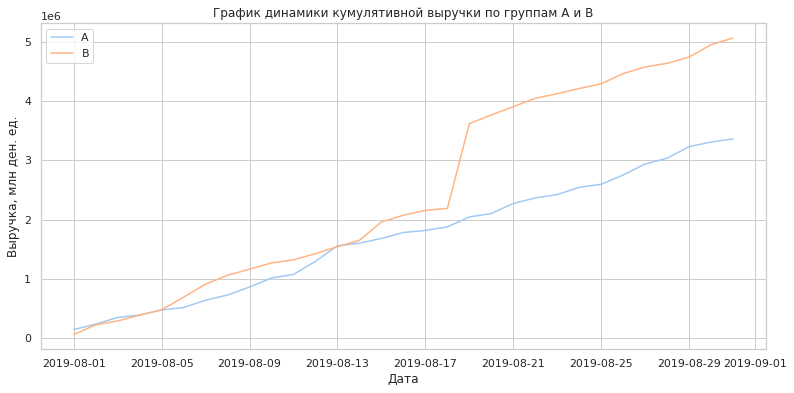

In [37]:
# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders', 'avg_check', 'conversion']]

# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе В
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders', 'avg_check', 'conversion']]

#зададим размер фигуры
plt.figure(figsize=(13,6))

# построим линейные графики для групп А и В
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

# зададим подписи на графике
plt.title('График динамики кумулятивной выручки по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн ден. ед.')
plt.legend()
plt.show()

Кумулятивная выручка группы А растет линейно и она ниже выручки группы В. У группы А - постоянный плавный рост, при том, что у группы В наблюдается резкий скачок выручки в районе 18-19 августа, что может свидетельствовать о всплесках или числа заказов, или их стоимости.

In [38]:
orders.groupby('date').agg({'transaction_id':'count', 'revenue':'sum'})

,transaction_id,revenue
date,,
2019-08-01,40,202537
2019-08-02,42,253645
2019-08-03,38,179522
2019-08-04,25,138066
2019-08-05,43,176291
2019-08-06,38,255761
2019-08-07,39,342412
2019-08-08,36,238780
2019-08-09,30,237403


19 августа наблюдается максимальная выручка за весь месяц, почти 1.6 млн ден. ед, количество заказов в этот день составило 42 при среднем количестве заказов в день ~ 33. Посмотри на данный день еще подробнее.

In [39]:
orders.query('date == "2019-08-19"').sort_values(by='revenue', ascending=False).head(6)

,transaction_id,visitor_id,date,revenue,group
365,590470918,1920142716,2019-08-19,1294500,B
453,3970235543,2912540959,2019-08-19,43990,A
450,1570513684,2837914161,2019-08-19,33405,B
361,3765974140,1357170471,2019-08-19,31680,A
393,2683113224,154576532,2019-08-19,26550,B
316,3268879337,2536252163,2019-08-19,20026,B


Т.об., мы видим, что имел место один заказ №365 на ~ 1,3 млн ден. ед. в группе "B" 19 августа 2021, который принес существенную часть дневной выручки в эту дату. Однако поскольку этот всего лишь один заказ, то его можно считать выбросом и при дальнейшем анализе это нужно будет учесть.

<a id="cum_avg_check"></a>
# График кумулятивного среднего чека по группам

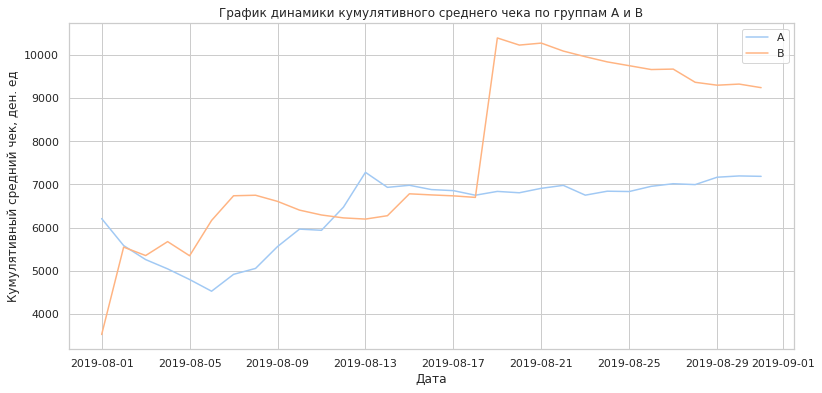

In [40]:
#зададим размер фигуры
plt.figure(figsize=(13,6))

# построим линейные графики для групп А и В
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['avg_check'],
         label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['avg_check'], 
         label='B')

# зададим подписи на графике
plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.xlabel('Дата')
plt.ylabel("Кумулятивный средний чек, ден. ед")
plt.legend()
plt.show()

<b> Графики кумулятивного среднего чека до середины теста нестабильны, имеется схожесть с графиком кумулятивной выручки. <b/>

В начале проведения теста мы видим сильные перепады как в большую, так и в меньшую сторону по обеим группам. Снова наблюдается резкий рост в группе В 19 августа. Ближе к концу теста колебания графиков снизились, группа А показывает незначительную тенденцию к росту, у группы В, начиная с 19 августа, график снижается.

# График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

In [46]:
cumulative_conversions_ab = (
    cumulative_revenue_a
    [['date','conversion']]
    .merge(
        cumulative_revenue_b[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['_a', '_b']
    )
)

cumulative_conversions_ab.head()

,date,conversion_a,conversion_b
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


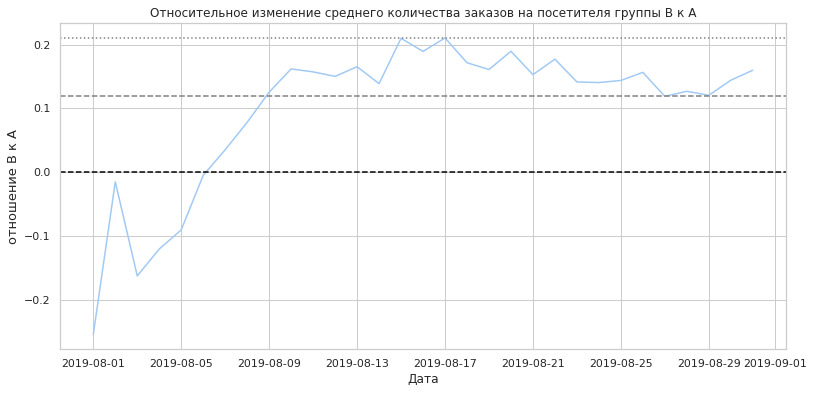

In [47]:
#зададим размер фигуры
plt.figure(figsize=(13,6))

# построим график относительного изменения кумулятивного среднего количества заказов на посетителя
plt.plot(
    cumulative_conversions_ab['date'], 
    cumulative_conversions_ab['conversion_b']/
    cumulative_conversions_ab['conversion_a']-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.12, color='grey', linestyle='--')
plt.axhline(y=0.21, color='grey', linestyle=':')

# добавляем ось X
plt.title('Относительное изменение среднего количества заказов на посетителя группы B к A')
plt.xlabel('Дата')
plt.ylabel('отношение В к А', fontsize = 13)
plt.show()

В начале августа среднее количество заказов на посетителя группы А было больше, однако с 6-го августа наметилась обратная тенденция, конверсия группы В росла, и начиная с 9 августа опережала аналогичный показатель группы А не менее, чем на 12%. Количество заказов на посетителя группы В выше, чем у посетителей группы А.
Однако не стоит забывать, что нами было установлено наличие выбросов в данных и необходим будет доп. анализ после очистки данных от выбросов.

<a id="order_quantity"></a>
# Точечный график количества заказов по пользователям.

Посчитаем количество заказов в разрезе пользователей.

In [48]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users.columns = ['visitor_id', 'orders']
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


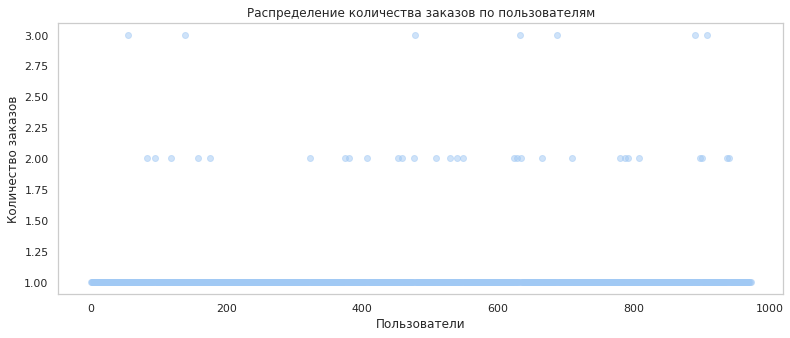

In [49]:
#настроим параметры фигуры
plt.figure(figsize=(13, 5)) 

x_values = pd.Series(range(0,len(orders_by_users)))

# строим точечную диаграмму
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)

# добавим подписи к графику
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов по пользователям')
plt.grid(False)
plt.show()

<b> Основная масса пользователей совершила одну покупку, существенно меньшее число - 2 покупки и единицы - 3 покупки. 

Примем за аномальных покупателей тех, кто совершил более 2х заказов

<a id="order_revenue"></a>
# Точечный график стоимостей заказов. <br>

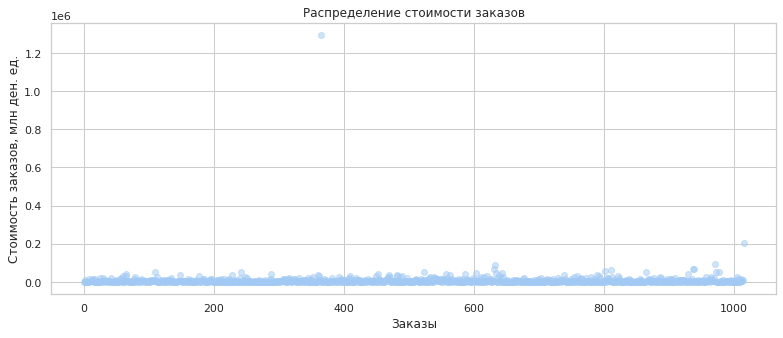

In [51]:
#настроим параметры фигуры
plt.figure(figsize=(13, 5)) 

x_values = pd.Series(range(0,len(orders['revenue'])))

# строим точечную диаграмму
plt.scatter(x_values, orders['revenue'], alpha=0.5)

# добавим подписи к графику
plt.title('Распределение стоимости заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказов, млн ден. ед.')
plt.show()

На графике мы видим крупный аномальный заказ. И что большинство остальных заказов не превышает 100-150 тыс. ден. ед.
Посмотрим на данные заказы поближе, задав ограничение значений по оси y, чтобы точки на графике не "сливались" настолько сильно.

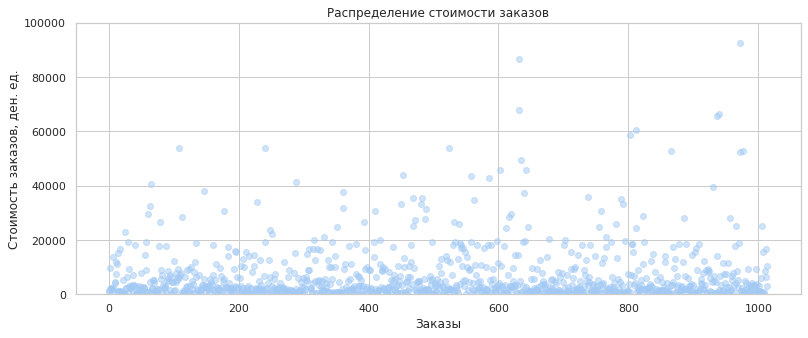

In [52]:
#настроим параметры фигуры
plt.figure(figsize=(13, 5)) 

x_values = pd.Series(range(0,len(orders['revenue'])))

# строим точечную диаграмму
plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'], alpha=0.5)

# добавим подписи к графику
plt.title('Распределение стоимости заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказов, ден. ед.')
plt.show()

На последнем граифке мы видим, что основная часть заказов не превышает 20 тыс. ден. ед. <br>
Посмотрим на 95 и 99 персентили, чтобы однозначно определить границу аномальной стоимости заказа.

#### 95-й и 99-й перцентили стоимости заказов.<br>

In [53]:
perc_95 = np.percentile(orders['revenue'], 95)
perc_99 = np.percentile(orders['revenue'], 99)
print(f'Не более 5% покупателей оформили заказ на суммы свыше {perc_95} ден. ед.')
print(f'Не более 1% покупателей оформили заказ на суммы свыше  {perc_99} ден. ед.')

Не более 5% покупателей оформили заказ на суммы свыше 26785.0 ден. ед.
Не более 1% покупателей оформили заказ на суммы свыше  53904.0 ден. ед.


Учитывая, что мы сохранили пользователей с 1-2 заказами и взяли более "мягкий" персентиль для определения границы аномальных значений, в данном случае за верхнюю границу примем значение 95 персентиля и все заказы, стоимость которых превышает ~ 27 тысяч ден. ед., будем расценивать как аномальные.

<a id="aplha_filt"></a>
# Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Примем за аномальных пользователей тех, кто совершил более 2х заказов или совершил заказ дороже 26 785 ден. ед. Так мы исключим 1% пользователей с наибольшим числом заказов и порядка 5% пользователей с дорогими заказами.

Сделаем срезы пользователей с числом заказов больше 2 — users_with_many_orders и пользователей, совершивших заказы дороже 27 тысяч ден. ед., — users_with_expensive_orders. Объединим их в таблице abnormal_users и узнаем, сколько всего аномальных пользователей.

In [66]:
abnormal_orders = np.percentile(orders_by_users['orders'], 99)
abnormal_revenue = np.percentile(orders['revenue'], 95)

In [67]:
users_with_many_orders = (pd
               .concat([orders_a[orders_a['orders'] > abnormal_orders]['visitors_id'], 
                        orders_b[orders_b['orders'] > abnormal_orders]['visitors_id']], 
                       axis=0)
              )

users_with_expensive_orders = orders[orders['revenue'] > abnormal_revenue]['visitor_id']

abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0).drop_duplicates().sort_values()

display(abnormal_users.head())
abnormal_users.shape[0]

487    113298937
937    148427295
792    204675465
33     249864742
586    358944393
dtype: int64

58

С учетом заданных границ в наших данных имеется 58 пользователей, совершивших аномальные заказы. <br> Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по очищенным данным.

Сформулируем гипотезы:

- Нулевая гипотеза (Н0) - различий в среднем количестве заказов между отфильтрованными группами нет. <br>
- 
Альтернативная (Н1) -различия в среднем между отфильтрованными группами естьь.

In [68]:
sample_a_filtered = (pd
            .concat([orders_a[np.logical_not(orders_a['visitors_id'].isin(abnormal_users))]['orders'], 
                     pd.Series(0, index=np.arange(visitors_a['visitors'].sum() - len(orders_a['orders'])), 
                               name='orders')],axis=0))

sample_b_filtered = (pd
            .concat([orders_b[np.logical_not(orders_b['visitors_id'].isin(abnormal_users))]['orders'], 
                     pd.Series(0, index=np.arange(visitors_b['visitors'].sum() - len(orders_b['orders'])), 
                               name='orders')],axis=0))

In [69]:
stat_significance(sample_a_filtered, sample_b_filtered)

P-value: 0.012
Отвергаем нулевую гипотезу: между группами есть разница
Относительная разница В к А: 18.190%


Как и в случае с сырыми данными p-value меньше уровня стат.значимости, а значит мы отвергаем нулевую гипотезу о равенстве в среднем количестве заказов на посетителя. Относительная разница группы В к группе А составила 18.2 %, при этом по "сырым" данным разница составляла 15,98%. Также в случае установления стат. значимости в 1% мы бы не отвергали нулевую гипотезу и отмечали бы, что оснований для того, чтобы отвергнуть нулевую гипотезу у нас недостаточно.

<b> Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

Подсчитаем статистическую значимость различий в среднем чеке после удаления аномальных пользователей.

Сформулируем гипотезы:

- Нулевая гипотеза (Н0) - различий в среднем чеке заказов между отфильтрованными группами нет.
- Альтернативная (Н1) - различия в среднем чеке между отфильтрованными группами есть.

In [70]:
stat_significance(
    orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'], 
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']
                  )

P-value: 0.646
Не удалось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительная разница В к А: -4.847%


P-value как и в случае с сырыми данными значительно больше 0.05 (уровень стат. значимости), причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Hо при этом относительная разница в пользу группы А составила почти 5%, в то время как по сырым данныи разница была почти 29% в пользу группы В.

<a id="filt_vis"></a>
# Построение графиков по «очищенным» данным

Подготовим данные и сформируем датафреймы по очищенным данным аналогично действиям, совершенным в начале исследовательского анализа. 

In [71]:
# исключим из датафрейма с заказами покупателей, входящих в список аномальных посетителей
orders_filtered = orders[np.logical_not(orders['visitor_id'].isin(abnormal_users))]

# создадим массив уникальных пар значений дат и групп теста
date_groups_filtered = orders_filtered[['date','group']].drop_duplicates() 

# получим агрегированные кумулятивные данные по дням о заказах 
agg_orders_filtered = (date_groups_filtered
                    .apply(lambda x: orders_filtered[np.logical_and(orders_filtered['date'] <= x['date'], 
                                                                    orders_filtered['group'] == x['group'])]
                           .agg({'date' : 'max', 
                                 'group' : 'max', 
                                 'transaction_id' : 'nunique', 
                                 'visitor_id' : 'nunique', 
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )

# получаем агрегированные кумулятивные данные по дням о посетителях 
agg_visitors_filtered = (date_groups_filtered
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                     )

# объединяем кумулятивные данные в одной таблице и присвоим ее столбцам более понятные названия
cum_data_filtered = agg_orders_filtered.merge(agg_visitors_filtered, left_on=['date', 'group'], right_on=['date', 'group'])
cum_data_filtered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# добавим столбец со средним чеком заказа
cum_data_filtered['avg_check'] = cum_data_filtered['revenue'] / cum_data_filtered['orders']

# добавим столбец с отношением заказов к количеству посетителей
cum_data_filtered['conversion'] = cum_data_filtered['orders']/cum_data_filtered['visitors']

# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cum_rev_a_filtr = cum_data_filtered[cum_data_filtered['group']=='A'][['date','revenue', 'orders', 'avg_check', 'conversion']]

# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе В
cum_rev_b_filtr = cum_data_filtered[cum_data_filtered['group']=='B'][['date','revenue', 'orders', 'avg_check', 'conversion']]

**Построим графики кумулятивной выручки по дням и группам A/B-тестирования:**

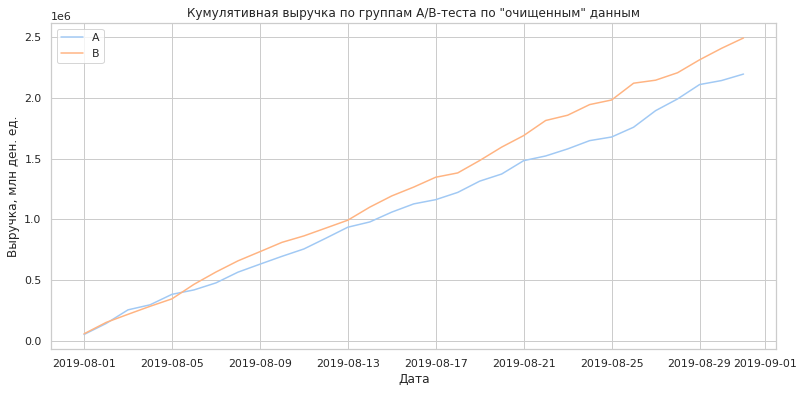

In [72]:
#зададим размер фигуры
plt.figure(figsize=(13,6))

# построим линейные графики для групп А и В
plt.plot(cum_rev_a_filtr['date'], cum_rev_a_filtr['revenue'], label='A')
plt.plot(cum_rev_b_filtr['date'], cum_rev_b_filtr['revenue'], label='B')

# зададим подписи на графике
plt.title('Кумулятивная выручка по группам A/B-теста по "очищенным" данным')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн ден. ед.')
plt.legend()
plt.show()

Кумулятивная выручка на всем протяжении теста также растет, но более плавно по обеим группам. <br>
По очищенным данным кумулятивная выручка группы В стабильно превышает показатели группы А после первой недели теста.

**Оценим относительное изменение кумулятивного среднего чека группы B к группе A по "очищенным" данным**

In [73]:
# соберем данные в один датафрейм
cum_rev_ab_filtr = cum_rev_a_filtr.merge(
    cum_rev_b_filtr, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# выведем на экран 2 случайные строки датафрейма
cum_rev_ab_filtr.sample(2)

,date,revenue_a,orders_a,avg_check_a,conversion_a,revenue_b,orders_b,avg_check_b,conversion_b
9,2019-08-10,696233,151,4610.814570,0.024114,811072,185,4384.172973,0.029473
26,2019-08-27,1893270,385,4917.584416,0.023510,2143759,442,4850.133484,0.026751


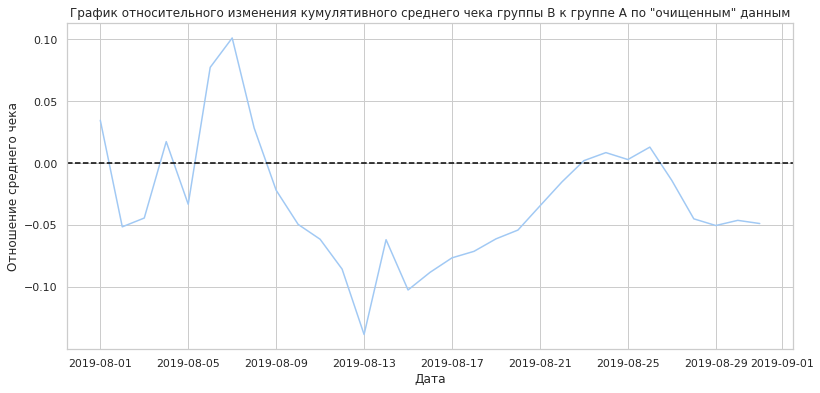

In [74]:
#зададим размер фигуры
plt.figure(figsize=(13,6))

# построим график соотношения средних чеков
plt.plot(cum_rev_ab_filtr['date'], 
        (cum_rev_ab_filtr['avg_check_b']) / (cum_rev_ab_filtr['avg_check_a'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# добавляем подписи данных
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A по "очищенным" данным')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека')
plt.show()

График среднего чека нестабилен и показывает фактически противоположную картину относительно графика по "сырым" данным. В данном случае большее количество дней теста значение кумулятивного среднего чека группы А было больше чем у группы В. Как мы выяснили ранее относительная разница группы А к группе В составляет 4.85% (4,847% при округлении до 3-х знаков после запятой).

**Оценим относительное изменение среднего количества заказов на посетителя группы B к группе A по "очищенным" данным**

In [75]:
cumulative_conversions_filt_ab = (
    cum_rev_a_filtr
    [['date','conversion']]
    .merge(
        cum_rev_b_filtr[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['_a', '_b']
    )
)

cumulative_conversions_filt_ab.head(3)

,date,conversion_a,conversion_b
0,2019-08-01,0.022253,0.023843
1,2019-08-02,0.025411,0.029366
2,2019-08-03,0.031436,0.028841


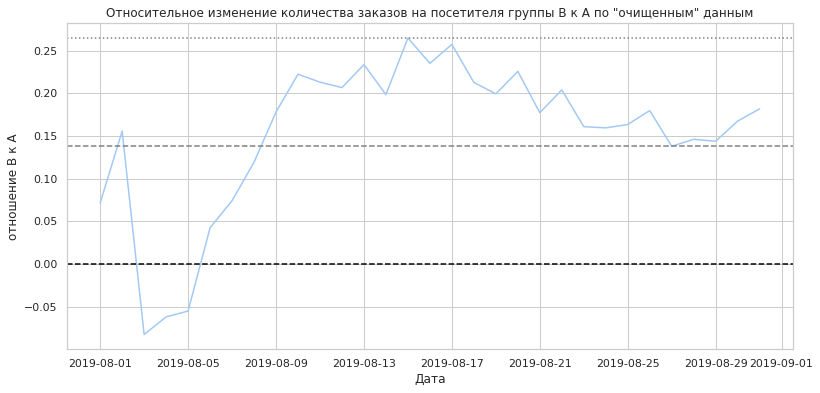

In [76]:
#зададим размер фигуры
plt.figure(figsize=(13,6))

# построим график относительного изменения кумулятивного среднего количества заказов на посетителя
plt.plot(
    cumulative_conversions_filt_ab['date'], 
    cumulative_conversions_filt_ab['conversion_b']/
    cumulative_conversions_filt_ab['conversion_a']-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.138, color='grey', linestyle='--')
plt.axhline(y=0.265, color='grey', linestyle=':')

# добавляем ось X
plt.title('Относительное изменение количества заказов на посетителя группы B к A по "очищенным" данным')
plt.xlabel('Дата')
plt.ylabel('отношение В к А')
plt.show()

По "сырым" данным среднее количество заказов на посетителя группы А превышало группу В приблизительно первую неделю теста, по "очищенным" данным превышает только пару дней в начале теста, также примерно с 6-го августа заказы на посетителя группы В опередили данный показатель группы А и больше ниже нулевой отметки не опускалась. Приблизительно с 9-го августа метрика группы В не опускалась ниже порядка 14% (по "сырым" данным не ниже 12%).

<a id="conclusions"></a>
# Общие выводы по итогам проекта:

- в части предоставленных нам данных явные пропуски и дубликаты отсутствовали, при этом в рамках предобработки мы исправили тип данных в столбцах с датой с object на datetime, скорректировали стиль наименования столбцов, где было необходимо;
- длительность теста составила 1 месяц - август 2019 года, в таблице `orders` был выявлен дисбаланс в количестве пользователей между группами, кроме того, 58 уникальных покупателей были включены в обе группы тестирования, с целью получения более объективных показателей тестирования данные покупатели были исключены из теста;
- для стоимости заказа (выручки от 1 заказа для интернет-магазина) характерен существенный разброс значений: минимальная стоимость заказа составила 50 ден. ед., максимальная же ~ 1.3 млн ден. ед., средняя стоимость заказа составила около 8348 ден. ед, медианная же стоимость заказа составила 2978 ден. ед., а чек 75% заказов не превышает 8290 ден. ед.;
- с помощью методов ICE и RICE были приоритезированы гипотезы, особое внимание стоит обратить на гипотезы №7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) и №0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей), которые оказались в топ-3 в рамках приоритезации с помощью обоих фреймворков. Стоит учитывать что фреймворк RICE, усиливает ICE параметром охвата - на сколько пользователей повлияет изменение, которое мы хотим внести;
- в качестве аномальных пользователей и размера выручки с заказа (на основании графиков и 95/99-персентилей) признаны покупатели, оформившие более двух заказов, а также заказы стоимость более ~27 тыс. ден. ед.;
- по результатам А/В теста было принято решение о его завершении и признании победы группы В: среднее количество заказов на посетителя группы В выше, как и показатель кумулятивной выручки (как по очищенным, так и по сырым данные). Показатели же среднего чека нестабильны на протяжении всего теста и разнонаправленны по "сырым" и "очищенным" данным (в т.ч. в связи с их очисткой от аномальных значений, в частиности заказа №365 на ~ 1,3 млн ден. ед. в группе "B" 19 августа 2021), по ним затруднительно сделать однозначные выводы, а продолжение тестирования может лишь привести к его существенному удорожанию.